In [30]:
import numpy as np
import matplotlib.pyplot as plt

from new_fft import new_fft, new_ifft, new_fft2
from frac_fft import frac_fft
from pad import pad, adj_pad

# PPFFT improvement

In the original paper, a 2D FFT is done on the image, before applying 1D IFFT on the columns of the output. This can easily be replaced by a 1D FFT on the line of the input.

In [3]:
def ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    """
    Pseudo-Polar Fast Fourier Transform on the basically horizontal lines.

    ## Parameters
    a : np.ndarray
        Input array of shape (n, n) where n is even.

    ## Returns
    y : np.ndarray
        Ouput array of shape (n+1, 2n+1).
    """
    n, _ = a.shape
    m = 2 * n + 1

    res = np.empty((n + 1, m), dtype=np.complex64)
    Id_hat = new_fft2(pad(a, new_shape=(n, m)))
    for k in range(m):
        q = Id_hat[:, k]
        ifft_q = new_ifft(q)
        pad_ifft_q = pad(ifft_q, (m,))
        frac_pad_ifft_q = frac_fft(pad_ifft_q, 2 * (k - n), n)
        adj_pad_frac_ifft_q = adj_pad(frac_pad_ifft_q, (n + 1,))
        res[:, k] = adj_pad_frac_ifft_q[::-1]

    return res

In [4]:
def new_ppfft_horizontal(a: np.ndarray) -> np.ndarray:
    """
    Pseudo-Polar Fast Fourier Transform on the basically horizontal lines.

    ## Parameters
    a : np.ndarray
        Input array of shape (n, n) where n is even.

    ## Returns
    y : np.ndarray
        Ouput array of shape (n+1, 2n+1).
    """
    n, _ = a.shape
    m = 2 * n + 1

    res = np.empty((n + 1, m), dtype=np.complex64)

    aux = new_fft(pad(a, new_shape=(n, m)))
    pad_aux = pad(aux, (m, m))

    for k in range(m):
        pad_ifft_q = pad_aux[:, k]
        frac_pad_ifft_q = frac_fft(pad_ifft_q, 2 * (k - n), n)
        adj_pad_frac_ifft_q = adj_pad(frac_pad_ifft_q, (n + 1,))
        res[:, k] = adj_pad_frac_ifft_q[::-1]

    return res

In [6]:
n = 10
im = np.random.rand(n, n)
print(np.allclose(new_ppfft_horizontal(im), ppfft_horizontal(im)))
print(np.max(np.abs(new_ppfft_horizontal(im) - ppfft_horizontal(im))))
n = 11
im = np.random.rand(n, n)
print(np.allclose(new_ppfft_horizontal(im), ppfft_horizontal(im)))
print(np.max(np.abs(new_ppfft_horizontal(im) - ppfft_horizontal(im))))

True
0.0
True
0.0


# Selection of points in onion-peeling

We can try to find a pattern in the way points should be selected.

I we can't, we can precompute them (in the same way it is done for the Toeplitz matrices), since the indices only depend on $n$.

In [8]:
from onion_peeling import find_closest

In [23]:
def build_y(k, n):
    """
    -(n//2) < k < 0
    """
    half_n = n // 2
    m = 2 * n + 1

    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)
    y_left = -4 * np.pi * np.arange(-half_n, k) / m
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    return np.concatenate((y_left, y_ppfft, y_right))

In [65]:
n = 10

for k in range(-(n // 2) + 1, 0):
    true_k = k + n // 2
    y = build_y(k, n)
    res = find_closest(y, n)
    print(res[true_k:-true_k] - true_k)

[ 0  1  2  4  5  6  8  9 10]
[ 0  2  3  5  7  8 10]
[ 0  2  5  8 10]
[ 0  5 10]


In [105]:
def new_find_closest(k, n):
    l = np.arange(k, -np.sign(k) - k, step=-np.sign(k))
    return n//2 + np.rint(- n * l / (2 * k)).astype(int)

In [106]:
for k in range(-(n // 2) + 1, 0):
    print(new_find_closest(k, n))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47 

The behavior of the two methods is similar. The only difference is when a target point has two closest neighbors, in which case the previous method chooses the first one in the list, whereas the second method chooses the other. This should not have any influence on the onion-peeling method.

In [68]:
n = 1000
k = np.random.randint(-(n // 2) + 1, 0)
y = build_y(k, n)

In [69]:
%timeit find_closest(y, n)

10.1 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%timeit new_find_closest(k, n)

10.3 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
n = 20
for k in range(-(n // 2) + 1, 0):
    print(np.max(np.abs(new_find_closest(k, n) - new_find_closest(-k, n))))

# Testing the new point selection

In [134]:
from fast_resampling import fast_compute_alpha
from onion_peeling import resample_row, initialize, onion_peeling
from ppfft import ppfft

In [160]:
def recover_row_negative(k, vert_ppfft, Id):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n, m = vert_ppfft.shape[0] - 1, vert_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_left = Id[true_k, :true_k]
    y_left = -4 * np.pi * np.arange(-half_n, k) / m

    known_I_D_right = Id[true_k, -true_k:][::-1]
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, true_k:-true_k] = res[true_k:-true_k]

    return res

    

def new_recover_row_negative(k, vert_ppfft, Id):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n, m = vert_ppfft.shape[0] - 1, vert_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    indices = new_find_closest(k, n)
    known_ppfft = np.take(known_ppfft, indices)
    y_ppfft = np.take(y_ppfft, indices)

    known_I_D_left = Id[true_k, :true_k]
    y_left = -4 * np.pi * np.arange(-half_n, k) / m

    known_I_D_right = Id[true_k, -true_k:][::-1]
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))
    y = np.concatenate((y_left, y_ppfft, y_right))
    print(y)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, true_k:-true_k] = res[true_k:-true_k]
    
    return res



In [136]:
def compute_true_Id(im):
    n = len(im)
    m = 2 * n + 1
    pad_im = pad(im, (m, m))
    return new_fft2(pad_im)[::2, ::2]

In [137]:
n = 200
im = np.random.rand(n, n)
Id = compute_true_Id(im)
hori, vert = ppfft(im)

In [138]:
for k in range(-(n // 2) + 1, 0):
    res1 = recover_row_negative(k, vert, Id)
    res2 = new_recover_row_negative(k, vert, Id)
    true_res = Id[k + n//2]
    if not np.allclose(res1, res2):
        print(f"Old error: {np.max(np.abs(res1 - true_res))}")
        print(f"New error: {np.max(np.abs(res2 - true_res))}")

Old error: 0.009384107182653704
New error: 0.0005717054869029913
Old error: 0.0020840558664232812
New error: 0.0005353623833643223
Old error: 0.0023007127388436806
New error: 0.00043741751500811445
Old error: 0.0013673771463682143
New error: 0.0005275458568533303
Old error: 0.0008572018339020513
New error: 0.00033043159533483303
Old error: 0.0006793520403765103
New error: 0.0004589824072557965
Old error: 0.0007020743023891133
New error: 0.0004492011570025743
Old error: 0.0007039010750540517
New error: 0.0003637613209537624
Old error: 0.0004697073677647078
New error: 0.0004474501930580483
Old error: 0.0005513894907970362
New error: 0.0005485593062446641
Old error: 0.0005145384107802747
New error: 0.0005098157226247702


In [161]:
def new_recover_row_positive(k, vert_ppfft, Id):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n, m = vert_ppfft.shape[0] - 1, vert_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    indices = new_find_closest(k, n)
    known_ppfft = np.take(known_ppfft, indices)
    y_ppfft = np.take(y_ppfft, indices)

    known_I_D_right = Id[true_k, : (n - true_k)][::-1]
    y_left = -4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_I_D_left = Id[true_k, (true_k - n) :]
    y_right = 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))
    print(y)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, (n - true_k) : (true_k - n)] = res[(n - true_k) : (true_k - n)]

    return res


def recover_row_positive(k, vert_ppfft, Id):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n, m = vert_ppfft.shape[0] - 1, vert_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_right = Id[true_k, : (n - true_k)][::-1]
    y_left = -4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_I_D_left = Id[true_k, (true_k - n) :]
    y_right = 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, (n - true_k) : (true_k - n)] = res[(n - true_k) : (true_k - n)]

    return res



In [140]:
for k in range(-(n // 2) + 1, 0):
    res1 = recover_row_positive(-k, vert, Id)
    res2 = new_recover_row_positive(-k, vert, Id)
    true_res = Id[-k + n//2]
    if not np.allclose(res1, res2):
        print(f"Old error: {np.max(np.abs(res1 - true_res))}")
        print(f"New error: {np.max(np.abs(res2 - true_res))}")

Old error: 0.009485585780016704
New error: 0.0005760659508832299
Old error: 0.002104428264281727
New error: 0.0005373650942027009
Old error: 0.002289286514510441
New error: 0.0004340333959650306
Old error: 0.001380111332109434
New error: 0.0005284566805687084
Old error: 0.0008591705195842034
New error: 0.00033040096140984345
Old error: 0.0006743200357788027
New error: 0.0004570254979971506
Old error: 0.0007008778872063924
New error: 0.00044809617186689684
Old error: 0.0007014253261401506
New error: 0.0003667975473761981
Old error: 0.00047743976236792017
New error: 0.00045100446371652115
Old error: 0.000553434295584379
New error: 0.0005496035900441722
Old error: 0.0005134768776007156
New error: 0.00051115434218515


In [162]:
def new_recover_col_negative(k, hori_ppfft, Id):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n, m = hori_ppfft.shape[0] - 1, hori_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    indices = new_find_closest(k, n)
    known_ppfft = np.take(known_ppfft, indices)
    y_ppfft = np.take(y_ppfft, indices)

    known_I_D_left = Id[:true_k, true_k]
    y_left = -4 * np.pi * np.arange(-half_n, k) / m

    known_I_D_right = Id[-true_k:, true_k][::-1]
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))
    print(y)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k:-true_k, true_k] = res[true_k:-true_k]

    return res


def recover_col_negative(k, hori_ppfft, Id):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n, m = hori_ppfft.shape[0] - 1, hori_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_left = Id[:true_k, true_k]
    y_left = -4 * np.pi * np.arange(-half_n, k) / m

    known_I_D_right = Id[-true_k:, true_k][::-1]
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)
    
    Id[true_k:-true_k, true_k] = res[true_k:-true_k]

    return res



In [142]:
for k in range(-(n // 2) + 1, 0):
    res1 = recover_col_negative(k, hori, Id)
    res2 = new_recover_col_negative(k, hori, Id)
    true_res = Id[:, k + n//2]
    if not np.allclose(res1, res2):
        print(f"Old error: {np.max(np.abs(res1 - true_res))}")
        print(f"New error: {np.max(np.abs(res2 - true_res))}")

Old error: 0.006541217559702812
New error: 0.0005165017118840157
Old error: 0.00247096823269048
New error: 0.0004291082366645214
Old error: 0.0022050201854014705
New error: 0.00044501670190334047
Old error: 0.0007363468149448386
New error: 0.0004082667893963543
Old error: 0.0005430134360383447
New error: 0.0005018110086688961
Old error: 0.0006656589125979812
New error: 0.0006244376065460825
Old error: 0.0008468829446634803
New error: 0.000839946121825232
Old error: 0.0008011716448159028
New error: 0.0005110990202809433
Old error: 0.00038884279479884797
New error: 0.00036266891018364294
Old error: 0.0005424847925851972
New error: 0.0005192873392705916
Old error: 0.0006060588565078234
New error: 0.0006103041772953972


In [163]:
def new_recover_col_positive(k, hori_ppfft, Id):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n, m = hori_ppfft.shape[0] - 1, hori_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    indices = new_find_closest(k, n)
    known_ppfft = np.take(known_ppfft, indices)
    y_ppfft = np.take(y_ppfft, indices)

    known_I_D_right = Id[: (n - true_k), true_k][::-1]
    y_left = -4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_I_D_left = Id[(true_k - n) :, true_k]
    y_right = 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))
    print(y)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[(n - true_k) : (true_k - n), true_k] = res[(n - true_k) : (true_k - n)]

    return res


def recover_col_positive(k, hori_ppfft, Id):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n, m = hori_ppfft.shape[0] - 1, hori_ppfft.shape[1]
    half_n = n // 2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_right = Id[: (n - true_k), true_k][::-1]
    y_left = -4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_I_D_left = Id[(true_k - n) :, true_k]
    y_right = 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_samples = np.concatenate((known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[(n - true_k) : (true_k - n), true_k] = res[(n - true_k) : (true_k - n)]

    return res



In [144]:
for k in range(-(n // 2) + 1, 0):
    res1 = recover_col_positive(-k, hori, Id)
    res2 = new_recover_col_positive(-k, hori, Id)
    true_res = Id[:, -k + n//2]
    if not np.allclose(res1, res2):
        print(f"Old error: {np.max(np.abs(res1 - true_res))}")
        print(f"New error: {np.max(np.abs(res2 - true_res))}")

Old error: 0.006646104460974055
New error: 0.0005180063310482215
Old error: 0.002498964721475901
New error: 0.00042928387998670593
Old error: 0.002210128905086071
New error: 0.0004429667583630218
Old error: 0.0007386435950978629
New error: 0.000406662494430807
Old error: 0.0005524460191713973
New error: 0.0005022577739311179
Old error: 0.0006665155541762446
New error: 0.0006229746013476972
Old error: 0.0008602673973226497
New error: 0.0008543722482688613
Old error: 0.0007960437510719042
New error: 0.0005268936857397485
Old error: 0.0003781333098105372
New error: 0.0003620205067427348
Old error: 0.0005415271676841711
New error: 0.0005187137607601597
Old error: 0.0005611092289474484
New error: 0.000559510616988486


In [165]:
def fast_onion_peeling(hori_ppfft, vert_ppfft):
    Id = initialize(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1

    for k in np.arange(-(n // 2) + 1, 0):
        print(k)
        new_recover_row_negative(k, vert_ppfft, Id)
        new_recover_row_positive(-k, vert_ppfft, Id)

        new_recover_col_negative(k, hori_ppfft, Id)
        new_recover_col_positive(-k, hori_ppfft, Id)


    Id[n // 2, n // 2] = hori_ppfft[0, n]

    return Id

In [166]:
im = np.random.rand(10, 10)
hori, vert = ppfft(im)
fast_onion_peeling(hori, vert)

-4
[ 2.991993    2.3935944   1.91487552  0.95743776  0.47871888 -0.
 -0.47871888 -0.95743776 -1.91487552 -2.3935944  -2.991993  ]
[-2.991993   -2.3935944  -1.91487552 -0.95743776 -0.47871888  0.
  0.47871888  0.95743776  1.91487552  2.3935944   2.991993  ]
[ 2.991993    2.3935944   1.91487552  0.95743776  0.47871888 -0.
 -0.47871888 -0.95743776 -1.91487552 -2.3935944  -2.991993  ]
[-2.991993   -2.3935944  -1.91487552 -0.95743776 -0.47871888  0.
  0.47871888  0.95743776  1.91487552  2.3935944   2.991993  ]
-3
[ 2.991993    2.3935944   1.7951958   1.07711748  0.71807832 -0.
 -0.71807832 -1.07711748 -1.7951958  -2.991993   -2.3935944 ]
[-2.3935944  -2.991993   -1.7951958  -1.07711748 -0.71807832  0.
  0.71807832  1.07711748  1.7951958   2.3935944   2.991993  ]
[ 2.991993    2.3935944   1.7951958   1.07711748  0.71807832 -0.
 -0.71807832 -1.07711748 -1.7951958  -2.991993   -2.3935944 ]
[-2.3935944  -2.991993   -1.7951958  -1.07711748 -0.71807832  0.
  0.71807832  1.07711748  1.7951958   2.

array([[ 3.66223526+2.57771707j, -0.14717408+3.02130938j,
        -4.22975492-1.34490895j, -1.24936545-3.04695058j,
        -2.41499019-2.64458704j,  2.07959437-3.04569507j,
        -0.42830473+2.74086571j, -0.69251251+2.07730341j,
        -1.35842228+1.58417368j, -0.95834756-5.43824673j,
         4.24250174-0.31073758j],
       [-1.12018454+2.47429323j,  3.63266567-1.11058247j,
         3.0721425 +1.08028426j, -1.71563272-1.20647383j,
        -2.06620429+1.81268841j, -1.46508962+2.59289989j,
         0.26888533+5.59036111j, -0.70057836-3.09078666j,
         5.06723538+0.86009102j, -1.31943415-1.50411377j,
        -0.33624732-0.38796631j],
       [-0.76074016+0.39893773j,  1.78738311+4.92206086j,
         0.66363072-2.49849874j,  0.83247836+2.00005147j,
        -1.84313711+0.68674502j,  4.57286771-6.82033776j,
        -4.24890263-0.92097993j, -1.99661978-1.00738838j,
        -0.13129165+2.2159718j ,  0.08837102+0.30045422j,
        -0.91683596-0.38014409j],
       [ 3.21030426+3.096178

In [153]:
im = plt.imread("Shepp_logan_240.png")
hori, vert = ppfft(im)

res1 = onion_peeling(hori, vert)
res2 = fast_onion_peeling(hori, vert)

In [155]:
Id = compute_true_Id(im)

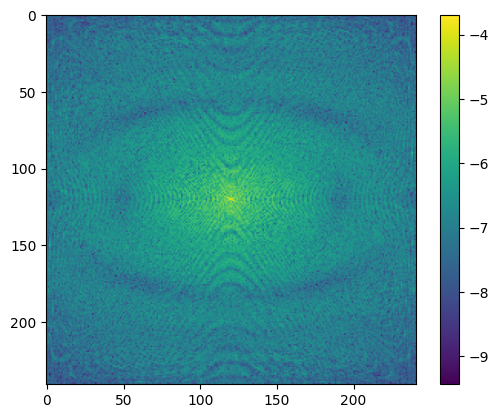

In [156]:
plt.imshow(np.log10(np.abs(res1 - Id)))
plt.colorbar()

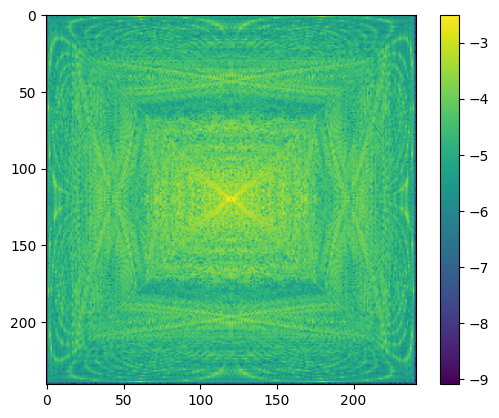

In [157]:
plt.imshow(np.log10(np.abs(res2 - Id)))
plt.colorbar()

TO DO:
- make the $y$ coordinates be the same for the 4 steps
- see if it's possible to make the diagonals + central line and column exact during onion-peeling
- the four step should accept the points to select as argument since they are the same for all 4. and $y$ too